In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # for CUDA 
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='cpu')

In [3]:
plt.rc("font", size=14)

# Extracting Drell-Yan Angular coefficients using Variational Autoencoders

*under construction*

In [4]:
class param_vae(nn.Module):
    def __init__(self, latent_dim: int = 8):
        super(param_vae, self).__init__()

        self.fc_encoder = nn.Sequential(
            nn.Linear(12* 12, 128, bias=True),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64, bias=True),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32, bias=True),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(32, latent_dim, bias=True)
        self.fc_logvar = nn.Linear(32, latent_dim, bias=True)

        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim+5, 32, bias=True),
            # nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 64, bias=True),
            # nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128, bias=True),
            # nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 12* 12, bias=True),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.fc_encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps* std
        
    def decode(self, z):
        reco = self.fc_decoder(z)
        return reco
        
    def forward(self, x, theta, label):
        # x = torch.cat((x, theta, label), dim=-1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = torch.cat((z, theta, label), dim=-1)
        reco = self.decode(z)
        return reco, mu, logvar

In [5]:
class param_loss(nn.Module):
    def __init__(self):
        super(param_loss, self).__init__()

    def reco_loss(self, reco, x):
        loss_fn = nn.BCELoss(reduction="sum")
        loss = loss_fn(reco, x)
        return loss

    def kld_loss(self, mu, logvar):
        loss =  -0.5* torch.sum(1.+ logvar- mu.pow(2)- logvar.exp())
        return loss
        
    def forward(self, reco, mu, logvar, x):
        reconstruction = self.reco_loss(reco, x)
        kl_divergence = self.kld_loss(mu, logvar)
        return (reconstruction + kl_divergence)/x.size(0)

In [6]:
def fit_param_vae(train_tree, batch_size, latent_dim, learning_rate, num_epochs, early_stopping_patience, plotson=False):

    X_data = train_tree["counts"].array().to_numpy()
    thetas = train_tree["theta"].array().to_numpy()
    label = train_tree["label"].array().to_numpy()

    X_train, X_val, theta_train, theta_val, Y_train, Y_val = train_test_split(X_data, thetas, label, test_size=0.3, shuffle=True)

    # conver to tensor
    X_train_tensor = torch.from_numpy(X_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    theta_train_tensor = torch.from_numpy(theta_train).float()
    theta_val_tensor = torch.from_numpy(theta_val).float()
    Y_train_tensor = torch.from_numpy(Y_train).float()
    Y_val_tensor = torch.from_numpy(Y_val).float()

    train_dataset = TensorDataset(X_train_tensor, theta_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, theta_val_tensor, Y_val_tensor)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = param_vae(latent_dim)

    # # Model summary
    # print("using device : {}".format(device))
    # total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print(model)
    # print("total trainable params: {}".format(total_trainable_params))

    
    criterion = param_loss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    trainig_loss, val_loss = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.
        for inputs, theta, label in train_dataloader:
            inputs = inputs.to(device)
            theta = theta.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            reco, mu, logvar = model(inputs, theta, label)
            loss = criterion(reco, mu, logvar, inputs)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()* inputs.size(0)
            
        epoch_loss = running_loss/len(train_dataloader.dataset)
        trainig_loss.append(epoch_loss)

        # evaluation
        model.eval()
        running_loss = 0.
        for inputs, theta, label in val_dataloader:
            inputs = inputs.to(device)
            theta = theta.to(device)
            label = label.to(device)
            
            reco, mu, logvar = model(inputs, theta, label)
            loss = criterion(reco, mu, logvar, inputs)
            running_loss += loss.item()* inputs.size(0)

        epoch_val = running_loss/len(val_dataloader.dataset)
        val_loss.append(epoch_val)

        if epoch%20 == 0:
            print("===> Epoch = {}/{} training loss = {:.3f} val. loss = {:.3f}".format(epoch, num_epochs, epoch_loss, epoch_val))
            
        # Check for early stopping
        if epoch_val < best_loss:
            best_loss = epoch_val
            best_model_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print("Early stopping at epoch {}".format(epoch))
            break

    if plotson==True :
        plt.plot(trainig_loss, label="train loss")
        plt.plot(val_loss, label="val. loss")
        plt.xlabel("epoch")
        plt.ylabel("loss [a.u.]")
        plt.legend(frameon=False)
        plt.show()
        
    return best_model_weights

In [7]:
class add_params(nn.Module):
    def __init__(self, params):
        super(add_params, self).__init__()
        self.params = nn.Parameter(torch.Tensor(params), requires_grad=True)
        
    def forward(self, inputs):
        batch_params = torch.ones((inputs.size(0), 1), device=inputs.device)* self.params.to(device=inputs.device)
        # concatenated = torch.cat([inputs, batch_params], dim=-1)
        return inputs, batch_params

In [8]:
def optimize_params(train_tree, secret_tree, batch_size, latent_dim, best_model_weights, nu_init, learning_rate, num_epochs, plotson=False):

    model = param_vae(latent_dim)
    model.load_state_dict(best_model_weights)
    
    # Set all weights in fit model to non-trainable
    for param in model.parameters():
        param.requires_grad = False

    add_param_model = add_params(nu_init)

    # Model summary
    # print("using device : {}".format(device))
    # total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # print(model)
    # print("total trainable params: {}".format(total_trainable_params))
    
    # total_trainable_params = sum(p.numel() for p in add_param_model.parameters() if p.requires_grad)
    # print(add_param_model)
    # print("total trainable params: {}".format(total_trainable_params))

    model = model.to(device)
    add_param_model = add_param_model.to(device)

    X_data = train_tree.arrays(["counts", "theta", "label"])

    X0 = X_data.counts[X_data.label[:, 0]==1.].to_numpy()
    theta0 = X_data.theta[X_data.label[:, 0]==1.].to_numpy()
    label0 = X_data.label[X_data.label[:, 0]==1.].to_numpy()

    X0_val, X0_extra, Y0_val, Y0_extra = train_test_split(X0, label0, train_size=30000, shuffle=True)

    # X1_data = secret_tree.arrays(["bin_count", "thetas", "label"])

    # X_secret = X1_data.bin_count[X1_data.label[:, 1]==1.].to_numpy()
    # # theta1 = X_data.thetas[X1_data.label[:, 1]==1.].to_numpy()
    # Y_secret = X1_data.label[X1_data.label[:, 1]==1.].to_numpy()

    X_secret = secret_tree["counts"].array().to_numpy()
    Y_secret = secret_tree["label"].array().to_numpy()

    X0_val_tensor = torch.from_numpy(X0_val).float()
    Y0_val_tensor = torch.from_numpy(Y0_val).float()
    
    X_secret_tensor = torch.from_numpy(X_secret).float()
    Y_secret_tensor = torch.from_numpy(Y_secret).float()

    X_tensor = torch.cat((X0_val_tensor, X_secret_tensor))
    Y_tensor = torch.cat((Y0_val_tensor, Y_secret_tensor))

    dataset = TensorDataset(X_tensor, Y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = param_loss()
    optimizer = optim.Adam(add_param_model.parameters(), lr=learning_rate)
    
    epoch_info = {"loss": [], "lambda": [], "nu": [], "mu": []}
    for epoch in range(num_epochs):
        add_param_model.train()
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            inputs, thetas = add_param_model(inputs)
            reco, mu, logvar = model(inputs, thetas, labels)
            loss = criterion(reco, mu, logvar, inputs)
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()* inputs.size(0)
        batch_loss = running_loss/len(dataloader.dataset)
        epoch_info["loss"].append(batch_loss)
        epoch_info["lambda"].append(add_param_model.params[0].item())
        epoch_info["mu"].append(add_param_model.params[1].item())
        epoch_info["nu"].append(add_param_model.params[2].item())

        if epoch%20 == 0:
            print("===> epoch = {}/{}, loss = {:.3f}, target = ({:.2f}, {:.2f}, {:.2f}), fit = ({:.2f}, {:.2f}, {:.2f})".format(epoch, num_epochs, batch_loss, 0.8, 0.1, 0.2, add_param_model.params[0].item(), add_param_model.params[1].item(), add_param_model.params[2].item()))

    if plotson==True:
        plt.plot(epoch_info["loss"])
        plt.xlabel("epoch")
        plt.ylabel("loss [a.u.]")
        plt.show()
        
        plt.plot(np.array(epoch_info["lambda"])/-0.8, label=r"$\lambda$", color="g")
        plt.plot(np.array(epoch_info["mu"])/-0.1, label=r"$\mu$", color="b")
        plt.plot(np.array(epoch_info["nu"])/0.2, label=r"$\nu$", color="m")
        plt.hlines(1.0, 0, len(epoch_info["lambda"]), colors="r", label="target")
        plt.xlabel("epoch")
        plt.ylabel(r"$\dfrac{\text{Fit value}}{\text{Target value}}$")
        plt.legend(frameon=False)
        plt.show()
        
    return epoch_info["lambda"][-1], epoch_info["mu"][-1], epoch_info["nu"][-1]

In [9]:
def fit_params(train_tree, secret_tree, batch_size, latent_dim, best_model_weights, learning_rate, num_epochs, num_iteration):

    tree = {"init_lambda": [], "init_mu": [], "init_nu": [], "opt_lambda": [], "opt_mu": [], "opt_nu": []}
    
    for iteration in range(num_iterations):
        lambda_init = np.random.uniform(0.0, 1.0)
        mu_init = np.random.uniform(-0.5, 0.5)
        nu_init = np.random.uniform(-0.5, 0.5)

        theta_init = [lambda_init, mu_init, nu_init]
        
        print("===> starting iteration {}, lambda init = {:.3f}, mu_init = {:.3f}, nu_init = {:.3f}".format(iteration, lambda_init, mu_init, nu_init))

        lambda_opt, mu_opt, nu_opt = optimize_params(train_tree, secret_tree, batch_size, latent_dim, best_model_weights, theta_init, learning_rate, num_epochs)

        tree["init_lambda"].append(lambda_init)
        tree["init_mu"].append(mu_init)
        tree["init_nu"].append(nu_init)
        tree["opt_lambda"].append(lambda_opt)
        tree["opt_mu"].append(mu_opt)
        tree["opt_nu"].append(nu_opt)
        
    outfile = uproot.recreate("result5.root", compression=uproot.ZLIB(4))
    outfile["tree"] = tree
    outfile.close()

In [10]:
latent_dim = 16
batch_size = 1024
learning_rate = 0.0001
early_stopping_patience = 10
num_epochs = 200
num_iterations = 50

In [11]:
# Load data
train_tree = uproot.open("vae_data_0.8_0.1_0.2.root:train_tree")
# train_tree = uproot.open("BinMCData.root:vae_tree")

===> Epoch = 0/200 training loss = 88.581 val. loss = 60.772
===> Epoch = 20/200 training loss = 5.855 val. loss = 5.852
===> Epoch = 40/200 training loss = 5.770 val. loss = 5.769
===> Epoch = 60/200 training loss = 5.764 val. loss = 5.764
===> Epoch = 80/200 training loss = 5.763 val. loss = 5.763
===> Epoch = 100/200 training loss = 5.762 val. loss = 5.762
===> Epoch = 120/200 training loss = 5.761 val. loss = 5.761
===> Epoch = 140/200 training loss = 5.761 val. loss = 5.761
===> Epoch = 160/200 training loss = 5.761 val. loss = 5.761
===> Epoch = 180/200 training loss = 5.761 val. loss = 5.761


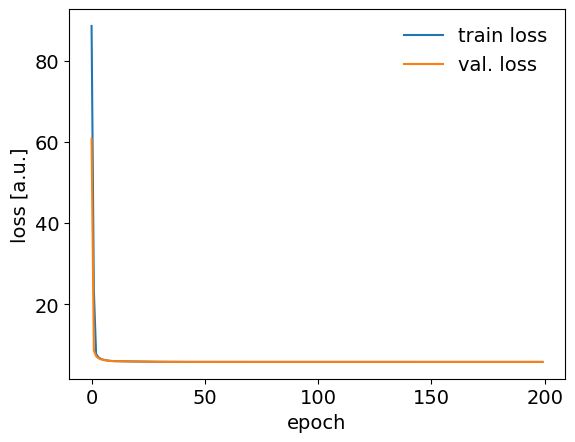

In [12]:
best_model_weights = fit_param_vae(train_tree, batch_size, latent_dim, learning_rate, num_epochs, early_stopping_patience, plotson=True)

In [13]:
# Load secret data
# secret_tree = uproot.open("vae_data_0.8_0.1_0.2.root:secret_tree")
# secret_tree = uproot.open("BinMCData.root:secret_tree")
secret_tree = uproot.open("vae_data_0.8_0.1_0.2.root:secret_tree")

===> epoch = 0/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.99, 0.01, 0.01)
===> epoch = 20/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.91, 0.07, 0.11)
===> epoch = 40/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.86, 0.09, 0.17)
===> epoch = 60/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.86, 0.10, 0.20)
===> epoch = 80/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.86, 0.10, 0.20)
===> epoch = 100/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> epoch = 120/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> epoch = 140/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> epoch = 160/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> epoch = 180/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)


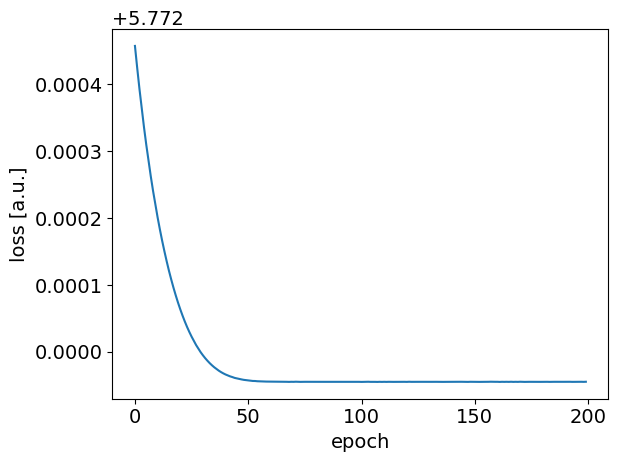

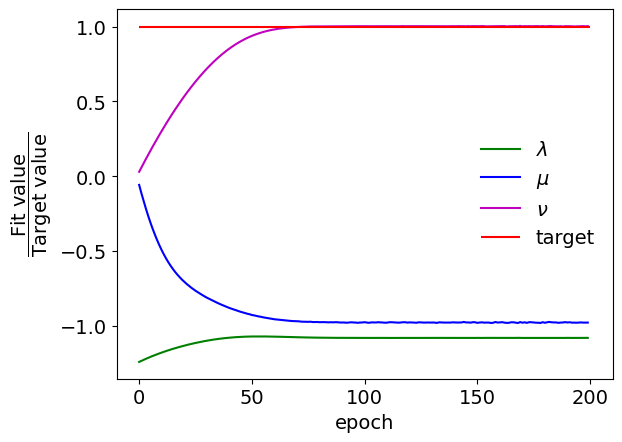

In [14]:
init_theta = [1.0, 0.0, 0.0]
#num_epochs = 400
opt_theta = optimize_params(train_tree, secret_tree, batch_size, latent_dim, best_model_weights, init_theta, learning_rate, num_epochs, plotson=True)

In [15]:
fit_params(train_tree, secret_tree, batch_size, latent_dim, best_model_weights, learning_rate, num_epochs, num_iterations)

===> starting iteration 0, lambda init = 0.519, mu_init = -0.234, nu_init = -0.051
===> epoch = 0/200, loss = 5.773, target = (0.80, 0.10, 0.20), fit = (0.51, -0.23, -0.04)
===> epoch = 20/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.43, -0.13, 0.06)
===> epoch = 40/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.49, -0.04, 0.13)
===> epoch = 60/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.62, 0.03, 0.17)
===> epoch = 80/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.73, 0.07, 0.19)
===> epoch = 100/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.81, 0.09, 0.20)
===> epoch = 120/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.85, 0.10, 0.20)
===> epoch = 140/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.86, 0.10, 0.20)
===> epoch = 160/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> epoch = 180/200, loss = 5.772, target = (0.80, 0.10, 0.20), fit = (0.87, 0.10, 0.20)
===> starting itera